In [2]:
# load pretty jupyter's magics
%load_ext pretty_jupyter

# **Introduction**  
Suicidal ideation detection in text is a critical task in mental health analysis, with potential applications in crisis intervention and social media monitoring. This notebook explores various machine learning models to classify text as either indicating suicidal ideation or not.  

Data source can be found at [kaggle](https://www.kaggle.com/datasets/mustofaahmed41/suicide-detection-dataset). The dataset is a collection of posts from "SuicideWatch" and "depression" subreddits of the Reddit platform.

## **Objective**  
The goal of this project is to develop a predictive model that can accurately classify text into two categories:  
- **Suicidal (1):** Texts that indicate suicidal ideation.  
- **Non-Suicidal (0):** Texts that do not suggest suicidal thoughts.  

We prioritize recall over precision, as missing a genuine case of suicidal ideation is a higher-risk scenario than incorrectly flagging a non-suicidal text.  

## **Dataset**  
The dataset used in this project consists of labeled text samples categorized as "suicide" or "non-suicide." Preprocessing steps include:  
- Tokenization  
- Stopword removal  
- Lemmatization  
- TF-IDF vectorization  

## **Methodology**  
1. **Data Preprocessing**  
   - Cleaning text using NLP techniques  
   - Converting categorical labels into numerical values  

2. **Model Training and Evaluation**  
   - Comparing multiple classifiers: Naive Bayes, Random Forest, K-Nearest Neighbors  
   - Performing cross-validation and hyperparameter tuning  
   - Evaluating models based on accuracy, precision, recall, and ROC-AUC scores  

3. **Error Analysis**  
   - Identifying false positives and false negatives  
   - Understanding misclassifications to improve model performance  

4. **Testing on Sample Texts**  
   - Evaluating model predictions on manually crafted example texts, ranging from direct suicidal statements to highly subtle expressions  

## **Key Findings**  
- Random Forest achieved the highest precision but lower recall.  
- Multinomial Naive Bayes (MNB) provided the best balance, with higher recall, making it the preferred model for deployment.  
- Texts with ambiguous or noisy language remain challenging for classification models.  

## **Next Steps**  
- Exploring deep learning-based approaches (e.g., transformers, LSTMs)  
- Incorporating context-aware embeddings like BERT for improved text representation  
- Addressing biases and improving robustness with larger, diverse datasets  

---
**Disclaimer:** This model is intended for research purposes and should not be used as a replacement for professional mental health assessment or intervention.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_predict,GridSearchCV
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,recall_score,precision_score,accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB,GaussianNB 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_validate
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
# Download necessary NLTK resources
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/arielmasper/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Load dataset
suicide = pd.read_csv('./Suicide_Detection.csv',usecols=['text','class'])

# Data Exploration

In [1]:
suicide.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [7]:
suicide[['class']].value_counts()

class      
non-suicide    116037
suicide        116037
Name: count, dtype: int64

In [17]:
sample_suicide = suicide.iloc[:5000]#We will limit the dataset to first 5,000 for faster computing

In [ ]:
sample_suicide.shape

In [18]:
sample_suicide[['class']].value_counts()#Label variable seems to be balanced

class      
non-suicide    2531
suicide        2469
Name: count, dtype: int64

In [19]:
sample_suicide['class'] = np.where(sample_suicide['class']=='suicide',1,0)#Converting label to numeric where suicide=1 non-suicide=0

/tmp/ipykernel_1960/53379021.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_suicide['class'] = np.where(sample_suicide['class']=='suicide',1,0)#Converting label to numeric where suicide=1 non-suicide=0


In [24]:
suicide.isna().sum()# Check for missing values

text     0
class    0
dtype: int64

In [11]:
suicide['text'].duplicated().sum()#check for missing text

np.int64(0)

In [12]:
sample_suicide = suicide.iloc[:5000]# Reducing dataset for faster processing.

In [13]:
sample_suicide[['class']].value_counts()#Dataset is still balanced

0

# Model Pipeline Setup

## Identify labels and features and split dataset into train and test

In [ ]:
# Labels and Features
y = sample_suicide['class']
X = sample_suicide.drop('class',axis=1)

Split dataset into train and test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2,random_state=42)

## Text Preprocessing

In [ ]:
def preprocess_text(text):
    """Tokenizes, lowercases, removes stop words, lemmatizes, and removes non-alphabetic tokens."""
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text.lower())
    preprocessed_text = ' '.join([lemmatizer.lemmatize(word) for word in tokens if word.isalpha()])
    return preprocessed_text

## Building and running pipeline on train data

Initialize TF-IDF vectorizer, fit, and transform text

In [31]:
text_preprocessor = FunctionTransformer(lambda X: [preprocess_text(t) for t in X], validate=False)

# Combine text preprocessing and vectorization into a pipeline
text_processing_pipeline = Pipeline([
    ('preprocessing', text_preprocessor), # Preprocessing step
    ('vectorization', TfidfVectorizer()) # TF-IDF vectorization
])

# Define the preprocessor for the whole dataset
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_processing_pipeline, 'text')  # Apply the combined pipeline only to the 'text' column
    ]
)

# Convert sparse to dense
dense_transformer = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

# Define a generic pipeline (with no specific model yet)
generic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_dense', None),
    ('model', None)  # Placeholder for model
])

In [32]:
# Define the model candidates
models = {
    'GaussianNB': GaussianNB(),
    'ComplementNB': ComplementNB(),
    'MultinomialNB': MultinomialNB(),
    'RandomForestClassifier':RandomForestClassifier(random_state=42),
    'KNeighborsClassifier':KNeighborsClassifier(),
}

In [ ]:
def plot_roc_curve():
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve for Suicide Classification')

In [34]:
model_color_dict = {
    'GaussianNB':'red',
    'ComplementNB':'blue',
    'MultinomialNB':'green',
    'RandomForestClassifier':'yellow',
    'KNeighborsClassifier':'brown'
    }

In [35]:
scoring = ['accuracy','roc_auc', 'precision', 'recall', 'f1']


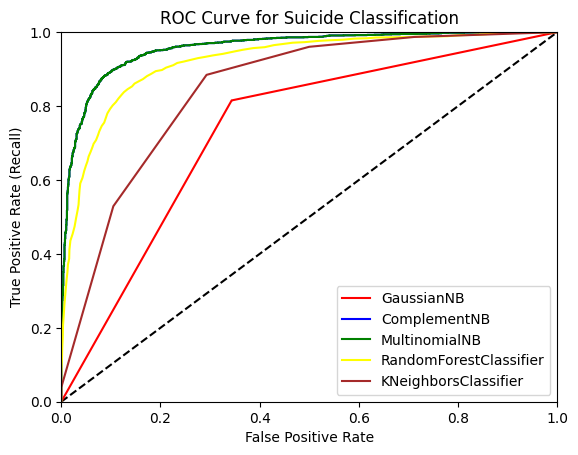

In [36]:
model_performance = pd.DataFrame()
plot_roc_curve()
# Loop through models and perform GridSearchCV for each one
for model_name, model in models.items():
    # Set the model in the pipeline
    generic_pipeline.set_params(model=model)
    if model_name == 'GaussianNB':
        generic_pipeline.set_params(to_dense=dense_transformer)
    else:
        generic_pipeline.set_params(to_dense=None)
    y_probas  = cross_val_predict(generic_pipeline,X_train,y_train,cv=3,method='predict_proba')[:,1]

    cv_results = cross_validate(generic_pipeline,X_train, y_train, cv=3, scoring=scoring)

    
    model_row = pd.DataFrame({
        'model_name':model_name,
        'AUV_score_mean': cv_results['test_roc_auc'].mean(),
        'AUV_score_std': cv_results['test_roc_auc'].std(),
        'Precision_mean': cv_results['test_precision'].mean(),
        'Precision_std': cv_results['test_precision'].std(),
        'Recall_mean': cv_results['test_recall'].mean(),
        'Recall_std': cv_results['test_recall'].std(),
        'F1_score_mean': cv_results['test_f1'].mean(),
        'F1_score_std': cv_results['test_f1'].std(),
        'Accuracy_mean': cv_results['test_accuracy'].mean(),
        'Accuracy_std': cv_results['test_accuracy'].std()
    },index=[0]
    )
    model_performance = pd.concat([model_performance,model_row])

    fpr_gnb,tpr_gnb,thresholds_gnb = roc_curve(y_train,y_probas)
    plt.plot(fpr_gnb,tpr_gnb,color = model_color_dict[model_name],label=model_name)


plt.legend(loc='lower right')
plt.show()

In [23]:
model_performance

,model_name,AUV_score_mean,AUV_score_std,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_score_mean,F1_score_std,Accuracy_mean,Accuracy_std
0,GaussianNB,0.735846,0.005570,0.701236,0.003380,0.815485,0.011038,0.754037,0.006294,0.735500,0.005547
0,ComplementNB,0.956643,0.007568,0.649470,0.007890,0.987934,0.002133,0.783691,0.005737,0.728750,0.009199
0,MultinomialNB,0.956643,0.007568,0.650848,0.007585,0.987431,0.001881,0.784540,0.005665,0.730250,0.008935
0,RandomForestClassifier,0.922331,0.009626,0.870487,0.005305,0.831574,0.024455,0.850427,0.014241,0.854754,0.011926
0,KNeighborsClassifier,0.855902,0.012523,0.752471,0.037849,0.884364,0.043091,0.811297,0.012798,0.795257,0.019172


Although the RandomForestClassifier achieved the best Precision score and high ROC AUC, we prioritize recall more in this case, as it's crucial for identifying individuals at risk. Identifying a text as at risk when it isn't is less problematic than failing to identify someone who is genuinely at risk. Therefore, we will use ComplementNB, which performed slightly better than the MultinomialNB model in terms of recall.

# Error analysis
[//]: # (-.- .tabset)

In [24]:
# Set the model in the pipeline
generic_pipeline.set_params(model=ComplementNB())

generic_pipeline.set_params(to_dense=None)

y_train_pred = cross_val_predict(generic_pipeline,X_train,y_train,cv=3)


In [25]:
X_tp = X_train[(y_train == 1) & (y_train_pred == 1)]
X_fn = X_train[(y_train == 1) & (y_train_pred == 0)]
X_fp = X_train[(y_train == 0) & (y_train_pred == 1)]
X_tn = X_train[(y_train == 0) & (y_train_pred == 0)]

## False positives

In [26]:
X_fp.head()

,text
4193,"go ahead, call the cops they can’t unpog you a..."
2968,What are your ways of procrastinating on compu...
4793,How to know if you have ADHD so basically rece...
4368,Do you ever wake up after moving thinking you ...
2970,just learned about Deuteronomy 23:2 wish i kne...


In [27]:
X_fp['text'].str.len().describe()

count    1061.000000
mean      427.495759
std       578.801953
min        22.000000
25%       128.000000
50%       218.000000
75%       467.000000
max      5212.000000
Name: text, dtype: float64

## False negatives

In [28]:
X_fn.head()

,text
3872,Catching the busDoes anyone know where the cat...
2835,Can somebody explain how should I use helium?Y...
2191,A song for anyone with mental illness who feel...
1123,"""just call this hotline, bro. it'll solve all ..."
1482,help this person i think op has 2 days [https:...


In [29]:
X_fn['text'].str.len().describe()

count      24.000000
mean      248.708333
std       484.468017
min        11.000000
25%        54.000000
50%       111.000000
75%       257.250000
max      2454.000000
Name: text, dtype: float64

## True positives

In [30]:
X_tp.head()

,text
4227,I might kill myself tomorrowLife is just too m...
4676,"I dont see things getting much betterClearly, ..."
800,Scared sister is going to do itMy dad and my s...
3671,Leaving for a while?Hi people. So yeah I've be...
2776,"Peace out, Good luck.Dear you,\n\nI just wante..."


In [31]:
X_tp['text'].str.len().describe()

count     1965.000000
mean      1018.918066
std       1184.737795
min         13.000000
25%        318.000000
50%        650.000000
75%       1272.000000
max      15669.000000
Name: text, dtype: float64

## True negatives

## TfidfVectorizer Fine-tuning
[//]: # (-.- .tabset)
Lets try to fine-tune the TfidfVectorizer to see if we get better results. We will try the following parameter combinations:
* `ngram_range`: 
    1. (1,1)(default)
    2. (1,2)
    3. (1,3)
* `stop_words`: 
    1. english
    2. None(default)


### ngram=(1,1); stop_words='english'

In [32]:
X_tn.head()

,text
4921,Cocaine vs butthole 1v1 \n\n&amp;#x200B;\n\nWh...
4916,Since this is text only weekend I will make a ...
4696,naw cus who wanna buy a mf some cat ears 🤣🤣???...
2834,"i hate being a girl but like, i don't wanna ge..."
2574,Did you know you carry a million of hitlers at...


In [33]:
X_tn['text'].str.len().describe()

count      950.000000
mean       215.732632
std        519.015600
min         21.000000
25%         86.250000
50%        132.000000
75%        218.500000
max      12651.000000
Name: text, dtype: float64

# Error Analysis Hypotheses:
* True positives often occur in longer texts, as the additional context and information might make it easier for the model to detect the target accurately.
* The model might struggle with texts containing misspellings, URLs, and slang, which can hinder proper detection.

# Grid Search for Hyperparameter Tuning

In [34]:
# Set the model in the pipeline
generic_pipeline.set_params(model=ComplementNB())

generic_pipeline.set_params(to_dense=None)
# Define the hyperparameter grid
param_grid = {
    'preprocessor__text__vectorization__ngram_range': [(1, 1), (1, 2),(1,3)],  # Tune n-gram range for TfidfVectorizer
    'preprocessor__text__vectorization__stop_words': [None,'english'],  # Tune stop_words for TfidfVectorizer
    'preprocessor__text__vectorization__max_df': [0.9, 1.0],  # Ignore very frequent words
    'preprocessor__text__vectorization__min_df': [1, 3],  # Ignore very rare words
    'preprocessor__text__vectorization__use_idf': [True, False],  # Use or ignore IDF
    'model__alpha': [0.1, 0.5, 1.0]  # Tune alpha for MultinomialNB
}


# Initialize Grid Search
grid_search = GridSearchCV(generic_pipeline, param_grid, cv=5,scoring='roc_auc')

# Fit and Evaluate
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'model__alpha': 0.1, 'preprocessor__text__vectorization__max_df': 0.9, 'preprocessor__text__vectorization__min_df': 1, 'preprocessor__text__vectorization__ngram_range': (1, 1), 'preprocessor__text__vectorization__stop_words': 'english', 'preprocessor__text__vectorization__use_idf': False}
Best score: 0.9667065036689921


# Model Evaluation

In [40]:
y_pred = grid_search.predict(X_test)

print(f'''
      Model metrics:
      ROC AUC score: {roc_auc_score(y_test,y_pred):.2f}
      f1 score: {f1_score(y_test,y_pred):.2f}
      Recall score: {recall_score(y_test,y_pred):.2f}
      Precision score: {precision_score(y_test,y_pred):.2f}
      Accuracy score: {accuracy_score(y_test,y_pred):.2f}
'''
)


      Model metrics:
      ROC AUC score: 0.86
      f1 score: 0.87
      Recall score: 0.95
      Precision score: 0.79
      Accuracy score: 0.86



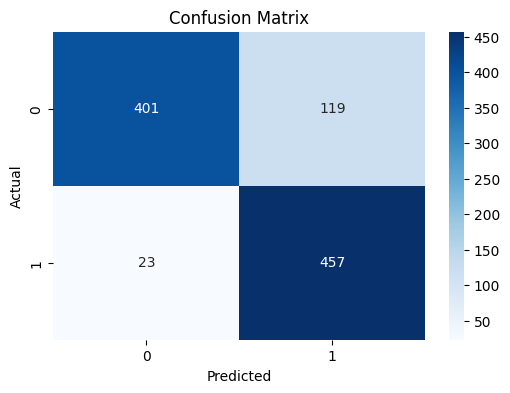

In [36]:
# Confusion matrix visualization
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Testing on Sample Texts

## How We Generated the Examples
We generated these examples using ChatGPT by specifically requesting text that indicates suicidal ideation with varying levels of subtlety and noise, including slang and external links.

The goal was to test the performance of our model, which was trained to detect suicidal ideation from text data. The examples were designed to simulate real-world scenarios, including:

* Direct and clear expressions of suicidal thoughts
* Subtle and indirect language
* Noisy and ambiguous text
* Slang-heavy language
* Messages with external links, which are common in social media posts

In [37]:
examples_df = pd.DataFrame({
    'Category': ['Direct_and_Clear', 'Moderately_Subtle', 'Highly_Subtle', 'Noisy_and_Ambiguous', 'Noisy_with_External_Links'],
    'text': [
        "I don’t even know why I’m writing this. I guess I just feel like I need to get it out somehow. I’ve tried so hard to keep going, to find a reason to stay, but it feels like no matter what I do, nothing changes. I wake up every day feeling empty, exhausted, like I’m just going through the motions for everyone else’s sake. And honestly? I don’t think I can keep pretending anymore. I just want the pain to stop. I don’t see a way forward. Maybe this is my way of saying goodbye.",
        "Lately, I’ve been thinking a lot about how things used to be. How different life was, how much easier it felt. It’s funny how things change, how people drift apart, how you can be surrounded by so many and still feel completely alone. I don’t know, maybe I’m just tired. Maybe I just need a break from everything. It’s just… hard to see the point sometimes, you know? Anyway, I hope you’re all doing well. Take care of yourselves.",
        "You ever get that feeling like you’re standing at the edge of something? Not necessarily bad, just… different. Like maybe things are about to change, one way or another. I don’t know. Just been lost in my thoughts a lot lately. Hope everyone’s good.",
        "man idk wut it iz but sumtimez it feelz like no matter how much u try u jus keep fallin bak into the same place. u ever jus sit there n wonder if it even matterz anymore?? idk lol maybe im just trippin. anyway stay safe yall.",
        "yooo been thinkin a lot lately bout how sht workzz. weird how u can do evrything rite n still feel lyk u got nuthin left. idk mayb i jus need sum rest or wutevr. if any1 feelin like dis too check out www.ithinkimdone.net idk just a thought."
    ]
})

In [38]:
exmp_text = examples_df.drop('Category',axis=1)

In [39]:
examples_df['pred'] = grid_search.predict(exmp_text)
examples_df

,Category,text,pred
0,Direct_and_Clear,I don’t even know why I’m writing this. I gues...,1
1,Moderately_Subtle,"Lately, I’ve been thinking a lot about how thi...",1
2,Highly_Subtle,You ever get that feeling like you’re standing...,1
3,Noisy_and_Ambiguous,man idk wut it iz but sumtimez it feelz like n...,0
4,Noisy_with_External_Links,yooo been thinkin a lot lately bout how sht wo...,0


The model successfully classified the first three categories of the example texts:
1. Direct_and_Clear
2. Moderately_Subtle
3. Highly_Subtle

However, the model failed to identify the last two:
4. Noisy_and_Ambiguous
5. Noisy_with_External_Links

### Observations
* The direct and clear expressions of distress were correctly detected.
* The model struggled with noisy text, such as slang, misspellings, and external links, which is common in social media posts and online forums.

### Potential Solutions
1. Larger Training Corpus:
* Training the model on more diverse and informal datasets can help it better understand noisy language patterns.

2. Data Preprocessing:
* Spelling correction
* URL removal or masking
* Slang normalization